<a href="https://colab.research.google.com/github/EnterTheBeginning/Machine-Learning/blob/master/HW3_Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import os
import zipfile

from keras.layers import Dense,Dropout,Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers

Using TensorFlow backend.


##Preprocessing

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2019-04-16 17:46:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  62.1MB/s    in 1.1s    

2019-04-16 17:46:03 (62.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()


In [4]:
generator = ImageDataGenerator(rescale = 1./255)

train_generator = generator.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)
validation_generator = generator.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
conv_base = VGG19(weights ='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step


##Feature Extraction

In [6]:
%%time
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory, target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i = 0
  for input_batch, labels_batch in generator:
    features_batch = conv_base.predict(input_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 16.9 s, sys: 6.03 s, total: 22.9 s
Wall time: 22.8 s


##Model 1 Without Augmentation

In [7]:
from keras import optimizers
model = Sequential()
model.add(Dense(256,input_dim=4*4*512))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, 
          train_labels, 
           epochs=30, 
            batch_size=20, 
              validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 746us/step - loss: 0.6338 - acc: 0.6615 - val_loss: 0.4398 - val_acc: 0.8090
Epoch 2/30
2000/2000 [==============================] - 1s 276us/step - loss: 0.4305 - acc: 0.7950 - val_loss: 0.3694 - val_acc: 0.8280
Epoch 3/30
2000/2000 [==============================] - 1s 273us/step - loss: 0.3622 - acc: 0.8350 - val_loss: 0.3271 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 1s 269us/step - loss: 0.3196 - acc: 0.8610 - val_loss: 0.3092 - val_acc: 0.8660
Epoch 5/30
2000/2000 [==============================] - 1s 272us/step - loss: 0.2832 - acc: 0.8845 - val_loss: 0.3104 - val_acc: 0.8560
Epoch 6/30
2000/2000 [==============================] - 1s 265us/step - loss: 0.2634 - acc: 0.8970 - val_loss

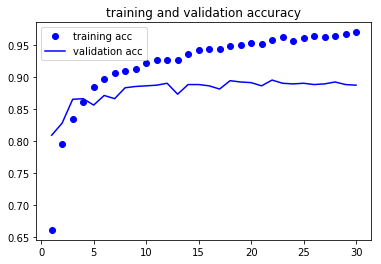

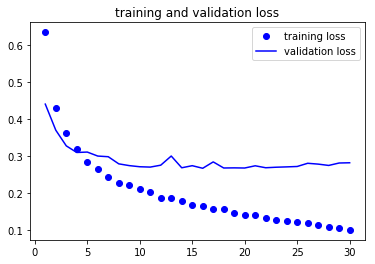

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

##Model 2 With Data Augmentation

In [31]:
from keras.layers import Flatten
#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(1,activation ='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])
history2 = model2.fit_generator(train_generator,steps_per_epoch=100,epochs=30,
                                validation_data=validation_generator,validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 32s 324ms/step - loss: 0.5261 - acc: 0.7185 - val_loss: 1.0356 - val_acc: 0.6450
Epoch 2/30
100/100 [==============================] - 28s 285ms/step - loss: 0.2909 - acc: 0.8760 - val_loss: 0.4746 - val_acc: 0.7560
Epoch 3/30
100/100 [==============================] - 29s 286ms/step - loss: 0.2178 - acc: 0.9030 - val_loss: 0.2433 - val_acc: 0.8860
Epoch 4/30
100/100 [==============================] - 28s 279ms/step - loss: 0.1731 - acc: 0.9300 - val_loss: 0.2616 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 28s 283ms/step - loss: 0.1658 - acc: 0.9340 - val_loss: 0.2500 - val_acc: 0.9020
Epoch 6/30
100/100 [==============================] - 28s 283ms/step - loss: 0.1395 - acc: 0.9460 - val_loss: 0.1497 - val_acc: 0.9400
Epoch 7/30
100/100 [==============================] - 28s 282ms/step - loss: 0.1229 - acc: 0.9505 - val_lo

In [43]:
score= model2.evaluate_generator(validation_generator,steps = 50)
print("Loss :",score[0])
print("Accuracy: ",score[1])

Loss : 0.11294988745765294
Accuracy:  0.9739999938011169


Results in 97% accuracy 

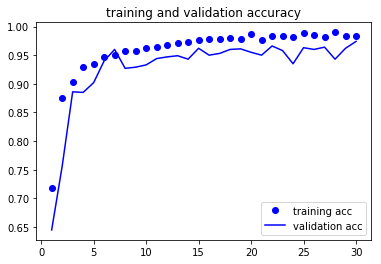

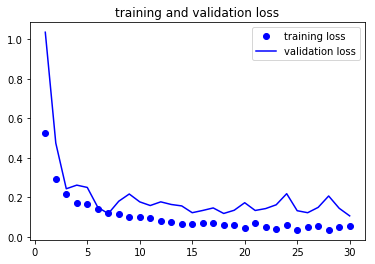

In [44]:
#Plot the results
acc = history2.history['acc']
val_acc = history2.history['val_acc']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()